# ML for NLP and text analytics

The online store "WikiShop" is launching a new service. Now users can edit and enhance product descriptions, similar to wiki communities. In other words, customers can suggest their edits and comment on the changes made by others. The store requires a tool that can detect toxic comments and send them for moderation.

**Tasks**

- Prepare the data.
- Train models to classify comments as positive or negative.
- Achieve a quality metric of F1 score of at least 0.75.
- Draw conclusions.



**Data Description**

 The column `text` contains the text of the comment, and `toxic` is the target feature.

## Data pre-processing

### Import Libraries

In [1]:
!pip install tqdm

In [2]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 1.9 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.1/491.1 kB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.6 MB/s eta 0:00:0000:0100:01


In [17]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [47]:
import warnings
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
import time
from nltk.corpus import stopwords
from catboost import CatBoostClassifier



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

### Helper Functions

In [19]:
def get_data_info(data):
    display(data.sample(5))
    data.info()
    display(data.describe(include='all'))

def get_numerical_summary(data):
    total = data.shape[0]
    missing_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = data[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    else:
        print('There are no missing values')

### Data Loading

In [20]:
try:
    data = pd.read_csv("/Users/daria/Desktop/toxic_comments.csv")
except:
    data = pd.read_csv('https://code.s3.yandex.net///datasets/toxic_comments.csv')

In [21]:
get_data_info(data)

,Unnamed: 0,text,toxic
17857,17874,""":::, I went hunting in the jungle of sources,...",0
119417,119522,"Tan, what have I done wrong?",0
82327,82405,Article title \n\nI moved this article to Jose...,0
8578,8590,"Dreadnought? \n\nPardon the ignorance, but was...",0
71806,71876,"Thanks, I appreciated. )",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
count,159292.000000,159292,159292.000000
unique,NaN,159292,NaN
top,NaN,Explanation\nWhy the edits made under my usern...,NaN
freq,NaN,1,NaN
mean,79725.697242,NaN,0.101612
std,46028.837471,NaN,0.302139
min,0.000000,NaN,0.000000
25%,39872.750000,NaN,0.000000
50%,79721.500000,NaN,0.000000
75%,119573.250000,NaN,0.000000


In [22]:
get_numerical_summary(data)

There are no missing values



No missing values were found. There is an uninformative feature called "Unnamed: 0" which is likely a result of data import. We will remove it.

In [23]:
data = data.drop(['Unnamed: 0'], axis=1)

In [24]:
data.columns

Index(['text', 'toxic'], dtype='object')

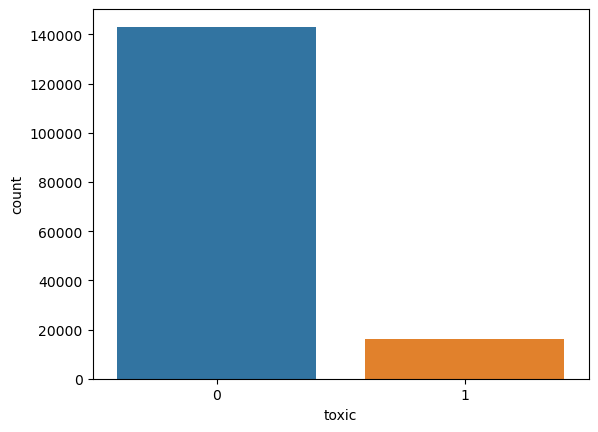

In [25]:
sns.countplot(data=data, x="toxic")
plt.show()

We observe that the features are not balanced. The majority of comments are not classified as toxic. This imbalance needs to be taken into account during model training, as it can lead to biased predictions.

### Text preprocessing

In [26]:
data['text'] = data['text'].apply(lambda x: ' '.join(re.sub(r'[^a-z\' ]', ' ', x.lower()).split()))
data['text'] = data['text'].apply(lambda x: re.sub(r'(\s\'\s)', '\'', x))

In [27]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


###  Spacy

In [28]:
nlp = spacy.load("en_core_web_sm")

In [29]:
texts = list(data['text'])
tokens_lemmatized = []
for doc in tqdm(nlp.pipe(texts), desc='Processing', unit='text', total=len(texts)):
    tokens_lemmatized.append([token.lemma_ for token in doc])
    
data['lemmatized_tokens'] = [' '.join(tokens) for tokens in tokens_lemmatized]


Processing: 100%|████████████████████| 159292/159292 [25:34<00:00, 103.79text/s]


In [30]:
data['lemmatized_tokens'].head()

0    explanation why the edit make under my usernam...
1    d'aww he match this background colour I be see...
2    hey man I be really not try to edit war it be ...
3    more I can not make any real suggestion on imp...
4    you sir be my hero any chance you remember wha...
Name: lemmatized_tokens, dtype: object

In [31]:
data.head()

,text,toxic,lemmatized_tokens
0,explanation why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,d'aww he matches this background colour i'm se...,0,d'aww he match this background colour I be see...
2,hey man i'm really not trying to edit war it's...,0,hey man I be really not try to edit war it be ...
3,more i can't make any real suggestions on impr...,0,more I can not make any real suggestion on imp...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


### TF-IDF

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dariadzhioeva/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
stop_words = list(set(stopwords.words('english')))

In [34]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

### Data split

In [35]:
cols = ['text', 'toxic', 'lemmatized_tokens']
df = pd.DataFrame(data, columns=cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   text               159292 non-null  object
 1   toxic              159292 non-null  int64 
 2   lemmatized_tokens  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [36]:
features = df.drop(columns=['text', 'toxic'])
target = df['toxic']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, 
                                                    random_state=42, 
                                                    stratify=target, 
                                                    )

In [38]:
X_train_transformed = count_tf_idf.fit_transform(X_train['lemmatized_tokens'])
X_test_transformed = count_tf_idf.transform(X_test['lemmatized_tokens'])

## Model Traning

### Logistic Regression

In [39]:
%%time


params = {'C': np.arange(0.5, 8.0, 2.8),
        'max_iter': [i for i in range(150, 251, 50)]}

model_lr = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid = params, cv=3, scoring='f1')
model_lr.fit(X_train_transformed, y_train)

print('Best F1-score: {:.2f}'.format(model_lr.best_score_))
print('Best params: ', model_lr.best_params_)

Best F1-score: 0.77
Best params:  {'C': 6.1, 'max_iter': 150}
CPU times: user 58.8 s, sys: 34.4 s, total: 1min 33s
Wall time: 48.8 s


### Decision Tree Classifier

In [49]:
%%time
model = DecisionTreeClassifier(random_state = 42)
params = {
   'criterion':['gini', 'entropy'],        
   'max_depth':list(range(1,15,5)) 
}
tree_gs = GridSearchCV(model, params, cv=3, scoring='f1', verbose=False).fit(X_train_transformed, y_train)
#predictions = tree_gs.predict(X_test_transformed) 
print('Best F1-score: {:.2f}'.format(tree_gs.best_score_))
print('Best params: ', tree_gs.best_params_)

Best F1-score: 0.61
Best params:  {'criterion': 'gini', 'max_depth': 11}
CPU times: user 2min 6s, sys: 729 ms, total: 2min 7s
Wall time: 2min 8s


## Model testing

In [50]:
y_pred = model_lr.predict(X_test_transformed)

f1_test = f1_score(y_test, y_pred)

print('F1-score: {:.2f}'.format(f1_test))

F1-score: 0.76


### ROC-AUC

AUC: 0.8934866871710941


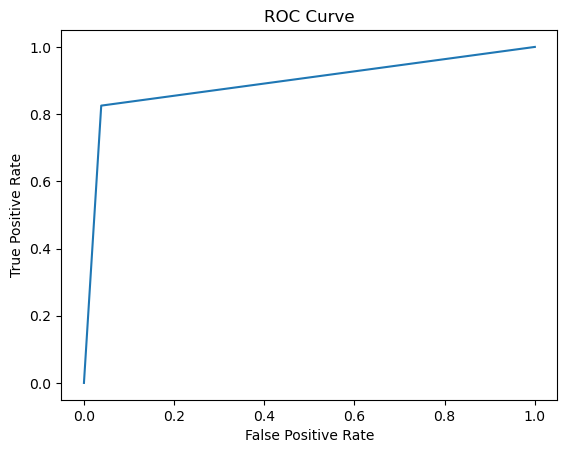

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)



plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

### Confusion Matrix

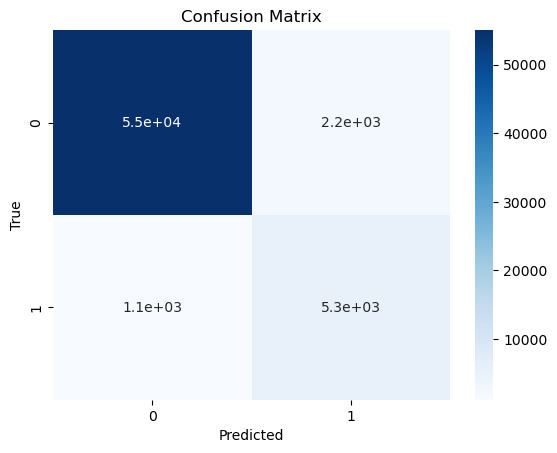

In [52]:
cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, cmap='Blues')


plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

## Conclusions

- There are a total of 159,571 records with text and sentiment labels, without any missing values or duplicates. However, toxic comments account for approximately 1/9th of the positive comments, leading to a class imbalance that we dealt with during training. We decided not to perform sampling as it distorted the predictions by balancing the class distribution.

- Next, we proceeded with text tokenization, lemmatization, and TF-IDF transformation. We used the spacy library to tokenize the text, removed stop words, and performed lemmatization. We then transformed the training data and vectorized the test data using TF-IDF.

- The best-performing model was the Logistic Regression model, with an accuracy of 0.77 on the training set and 0.76 on the test set. However, upon analyzing the ROC-AUC curve and the confusion matrix, we noticed that there were 1,132 true positive results in the matrix, indicating that the model is not handling the classification of toxic comments as effectively as non-toxic ones. To address this situation, I would recommend the business to gather more data and consider sending flagged comments for manual moderation to improve the model's performance.